## Gather

In [392]:
# library imports
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read twitter-archive-enhanced csv to df
archive_df = pd.read_csv('Data/twitter-archive-enhanced.csv')

In [3]:
# download image predictions tsv file and read it to a df
dl_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
filename = dl_url.split('/')[-1]

response = requests.get(dl_url)

with open('Data/' + filename, 'wb') as infile:
    infile.write(response.content)
    
prediction_df = pd.read_csv('Data/' + filename, sep='\t')

In [4]:
# read twitter config file
with open('twitter_config.json') as json_file:
    json_data = json.load(json_file)

# assign keys to variables
access_token = json_data['access_token']
access_token_secret = json_data['access_token_secret']
consumer_key = json_data['consumer_key']
consumer_secret = json_data['consumer_secret']

In [5]:
# creat api object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [7]:
# get API response and store it into a list
tweet_ids = list(archive_df.tweet_id)
tweet_list = []
for tweet_id in tweet_ids:
    try:
        status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_list.append(status._json)
    except Exception as e:
        print(e, str(tweet_id))

2356

In [32]:
len(tweet_ids), len(tweet_list)

(2356, 2342)

In [31]:
# save it to tweet_json.txt
with open('Data/tweet_json.txt', 'w') as file:
    for i in tweet_list:
        file.write(json.dumps(i))
        file.write('\n')

In [150]:
# what to do with missing ids?

# missing_ids = ['754011816964026368','770743923962707968','771004394259247104','775096608509886464','802247111496568832',
#               '827228250799742977','837012587749474308','842892208864923648','845459076796616705','861769973181624320',
#               '866816280283807744','869988702071779329','873697596434513921','888202515573088257']
# missing_ids = [int(i) for i in missing_ids]

# for tweet_id in missing_ids:
#     try:
#         status = api_response.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#         tweet_list.append(status._json)
#     except Exception as e:
#         print(e, str(tweet_id))

[{'code': 144, 'message': 'No status found with that ID.'}] 754011816964026368
[{'code': 144, 'message': 'No status found with that ID.'}] 770743923962707968
[{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}] 771004394259247104
[{'code': 144, 'message': 'No status found with that ID.'}] 775096608509886464
[{'code': 144, 'message': 'No status found with that ID.'}] 802247111496568832
[{'code': 144, 'message': 'No status found with that ID.'}] 827228250799742977
[{'code': 144, 'message': 'No status found with that ID.'}] 837012587749474308
[{'code': 144, 'message': 'No status found with that ID.'}] 842892208864923648
[{'code': 144, 'message': 'No status found with that ID.'}] 845459076796616705
[{'code': 144, 'message': 'No status found with that ID.'}] 861769973181624320
[{'code': 144, 'message': 'No status found with that ID.'}] 866816280283807744
[{'code': 144, 'message': 'No status found with that ID.'}] 869988702071779329
[{'code': 144, 'message': 'No st

In [46]:
# read tweet_json.txt to store into DF
list_to_insert = []

with open('Data/tweet_json.txt', 'r') as infile:
    for i, line in enumerate(infile):
        tweet = json.loads(line)
        list_to_insert.append({'tweet_id': tweet['id'],
                            'retweets': tweet['retweet_count'],
                            'favorites': tweet['favorite_count']})

In [47]:
# check if the reading from file was successful
len(list_to_insert) == len(tweet_list)

True

In [53]:
tweet_df = pd.DataFrame(list_to_insert, columns=['tweet_id', 'retweets', 'favorites'])

In [89]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
tweet_id     2342 non-null int64
retweets     2342 non-null int64
favorites    2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


## Assess

We have now gathered 3 dataframes:
- `archive_df` from arhive downloaded from udacity 
- `prediction_df` from url
- `tweet_df` from twitter api response content

In [114]:
# increase column width for better readability
pd.set_option('display.max_colwidth', -1)

In [115]:
# create copies of each dataframes
archive_df_clean = archive_df.copy()
prediction_df_clean = prediction_df.copy()
tweet_df_clean = tweet_df.copy()

In [116]:
# merge archive_df and tweet_df
archive_tweet_df = pd.merge(left=archive_df_clean, right=tweet_df_clean, left_on='tweet_id', right_on='tweet_id', how='inner')
archive_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 2341
Data columns (total 19 columns):
tweet_id                      2342 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2342 non-null object
source                        2342 non-null object
text                          2342 non-null object
retweeted_status_id           168 non-null float64
retweeted_status_user_id      168 non-null float64
retweeted_status_timestamp    168 non-null object
expanded_urls                 2283 non-null object
rating_numerator              2342 non-null int64
rating_denominator            2342 non-null int64
name                          2342 non-null object
doggo                         2342 non-null object
floofer                       2342 non-null object
pupper                        2342 non-null object
puppo                         2342 non-null object
retweets                      23

In [117]:
# check for retweets. Logic: non-null retweeded_status_id rows are the retweets
archive_tweet_df[~archive_tweet_df.retweeted_status_id.isnull()].count()

tweet_id                      168
in_reply_to_status_id         0  
in_reply_to_user_id           0  
timestamp                     168
source                        168
text                          168
retweeted_status_id           168
retweeted_status_user_id      168
retweeted_status_timestamp    168
expanded_urls                 167
rating_numerator              168
rating_denominator            168
name                          168
doggo                         168
floofer                       168
pupper                        168
puppo                         168
retweets                      168
favorites                     168
dtype: int64

In [118]:
# check for dog names
archive_tweet_df.name.value_counts()

None            738
a               55 
Charlie         11 
Oliver          11 
Lucy            11 
Cooper          11 
Tucker          10 
Penny           10 
Lola            10 
Winston         9  
Bo              9  
Sadie           8  
the             8  
Buddy           7  
an              7  
Daisy           7  
Bailey          7  
Toby            7  
Koda            6  
Oscar           6  
Jax             6  
Stanley         6  
Rusty           6  
Leo             6  
Bella           6  
Jack            6  
Scout           6  
Milo            6  
Dave            6  
Alfie           5  
               ..  
infuriating     1  
Link            1  
Bloo            1  
Karma           1  
Stephanus       1  
Brownie         1  
Maisey          1  
Dixie           1  
Bruiser         1  
Andru           1  
Stephan         1  
Kona            1  
Callie          1  
unacceptable    1  
Monty           1  
Champ           1  
Snoop           1  
Lenox           1  
Jeffri          1  


In [119]:
# check for names
archive_tweet_df.name.sort_values()

1007    Abby        
1021    Abby        
924     Ace         
1919    Acro        
1313    Adele       
1920    Aiden       
76      Aja         
471     Akumi       
807     Al          
862     Albert      
1940    Albert      
140     Albus       
403     Albus       
1101    Aldrick     
2032    Alejandro   
366     Alexander   
1175    Alexanderson
477     Alf         
1602    Alfie       
359     Alfie       
2224    Alfie       
845     Alfie       
651     Alfie       
50      Alfy        
1687    Alice       
196     Alice       
1481    Amber       
1320    Ambrose     
2064    Amy         
2181    Amélie      
         ...        
1081    mad         
839     my          
327     not         
974     not         
1733    officially  
1192    old         
361     one         
979     one         
1922    one         
911     one         
188     quite       
164     quite       
2312    quite       
2016    space       
21      such        
1801    the         
2198    the  

In [122]:
# check if the dog name is indeed not there or extraction failed
archive_tweet_df.loc[839]

tweet_id                      765395769549590528                                                                                                                    
in_reply_to_status_id         NaN                                                                                                                                   
in_reply_to_user_id           NaN                                                                                                                                   
timestamp                     2016-08-16 03:52:26 +0000                                                                                                             
source                        <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>                                                    
text                          This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
retweeted_

Dog names are tweeted with uppercase, so lowercase names are not real names

In [123]:
# get lowercase dog names
archive_tweet_df[archive_tweet_df.name.str.islower()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
21,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None,11622,45905
55,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None,15906,49125
164,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None,31353,91822
188,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None,8638,30786
327,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,None,None,None,None,568,3109
361,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,None,None,None,None,1480,10167
533,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11,10,incredibly,None,None,None,None,1339,6944
639,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1",13,10,a,None,None,None,None,4492,15588
672,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=

Visual inspection suggests that sometimes the dog names are there but not retrieved as they were not in 'This is ...' order. But many tweets do contain dog names in format 'named ...' or 'name is ...'

In [127]:
# check for records without images
archive_tweet_df[archive_tweet_df.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
29,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,4,116
54,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None,7,126
63,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None,10,311
111,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None,3,120
144,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,99,2292
174,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,19,236
180,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None,709,0
181,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None,17,530
183,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None,28,358
184,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None,1085,5166


In [132]:
# check for rating denominator. usually it is 10
archive_tweet_df.rating_denominator.value_counts()

10     2320
50     3   
80     2   
11     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [134]:
# so check for other records where rating_denominator is not 10
archive_tweet_df[archive_tweet_df.rating_denominator % 10 != 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
334,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None,2,71
507,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None,1593,5769
1054,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None,14467,36874
1648,682962037429899265,NaN,NaN,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7,11,Darrel,None,None,None,None,18198,39311
1649,682808988178739200,6.827884e+17,4.196984e+09,2016-01-01 06:22:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible",NaN,NaN,NaN,NaN,20,16,None,None,None,None,None,197,1880
2321,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None,64,149


In [136]:
# check numerator
archive_tweet_df.rating_numerator.value_counts()

12      553
11      464
10      461
13      345
9       157
8       102
7       55 
14      52 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [105]:
archive_tweet_df[archive_tweet_df.text.str.contains('puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,None,None,None,puppo,10012,47778
14,889531135344209921,NaN,NaN,2017-07-24 17:02:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13,10,Stuart,None,None,None,puppo,2224,14987
84,876120275196170240,NaN,NaN,2017-06-17 16:52:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https://t.co/ejExJFq3ek",NaN,NaN,NaN,https://twitter.com/dog_rates/status/876120275196170240/photo/1,13,10,Venti,None,None,None,None,4688,27735
93,874012996292530176,NaN,NaN,2017-06-11 21:18:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Sebastian. He can't see all the colors of the rainbow, but he can see that this flag makes his human happy. 13/10 #PrideMonth puppo https://t.co/XBE0evJZ6V",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/874012996292530176/photo/1,https://twitter.com/dog_rates/status/874012996292530176/photo/1",13,10,Sebastian,None,None,None,puppo,10482,34467
104,871879754684805121,NaN,NaN,2017-06-06 00:01:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Lassie. She's celebrating #PrideMonth by being a splendid mix of astute and adorable. Proudly supupporting her owner. 13/10 https://t.co/uK6PNyeh9w,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/871879754684805121/photo/1,https://twitter.com/dog_rates/status/871879754684805121/photo/1",13,10,Lassie,None,None,None,None,11292,37972
126,867421006826221569,NaN,NaN,2017-05-24 16:44:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Shikha. She just watched you drop a skittle on the ground and still eat it. Could not be less impressed. 12/10 superior puppo https://t.co/XZlZKd73go,NaN,NaN,NaN,https://twitter.com/dog_rates/status/867421006826221569/photo/1,12,10,Shikha,None,None,None,puppo,2570,16241
130,866686824827068416,NaN,NaN,2017-05-22 16:06:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lili. She can't believe you betrayed her with bath time. Never looking you in the eye again. 12/10 would puppologize profusely https://t.co/9b9J46E86Z,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/866686824827068416/photo/1,https://twitter.com/dog_rates/status/866686824827068416/photo/1",12,10,Lili,None,None,None,None,3558,19486
163,859607811541651456,NaN,NaN,2017-05-03 03:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859607811541651456/photo/1,13,10,None,None,None,None,puppo,1626,18946
167,858843525470990336,NaN,NaN,2017-05-01 00:40:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have stumbled puppon a doggo pain

In [80]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
tweet_id     2342 non-null int64
retweets     2342 non-null int64
favorites    2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [68]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [85]:
# check for duplicates in prediction_df
for i in list(prediction_df.tweet_id.duplicated()):
    if i:
        print('duplicated')

In [135]:
# check for the float numerator
archive_tweet_df[archive_tweet_df.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\Prayag\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
44,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,9918,45617
332,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,6790,0
685,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,6790,19714
753,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,1805,7090
1675,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None,302,1744
1698,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,524,1816


### Quality Issues
- Incorrect dtype to columns in `archive_tweet_df`. e.g. timestamp -> datetime
- Records representing retweets
- Subsequently, columns related to `retweeted_status_*`
- Records with no images (`expanded_url`)
- Float numerator in the `text` not correctly represented in column `rating_numerator`
- denominator that are not 10 (or multiples of 10)
- tweet_id `810984652412424192` does not have rating
- Incorrect dog names 
- No data values in dog names columns are 'None' as string dtype
- No data values as None in doggo, floofer, pupper, puppo

### Tidiness
- Consolidate doggo, floofer, pupper, puppo to one column `dog_stages`
- Potentially only keep `p1`, `p1_conf` and `p1_dog` columns in `prediction_df`
- Merge `archive_df` and `tweet_df` (already done!)

## Clean

#### Define
Assign correct datatypes to columns in `archive_tweet_df`
- timestamp -> datetime
- rating_numerator -> float

#### Code

In [140]:
# timestamp to datetime dtype
archive_tweet_df.timestamp = archive_tweet_df.timestamp.apply(pd.to_datetime)

In [145]:
# rating_numerator to float
archive_tweet_df.rating_numerator = archive_tweet_df.rating_numerator.astype(float)

#### Test

In [357]:
archive_tweet_df.dtypes

tweet_id                 int64         
in_reply_to_status_id    float64       
in_reply_to_user_id      float64       
timestamp                datetime64[ns]
source                   object        
text                     object        
expanded_urls            object        
rating_numerator         float64       
rating_denominator       int64         
name                     object        
retweets                 int64         
favorites                int64         
dog_stage                object        
dtype: object

#### Define
Remove records pertaining to retweets

#### Code

In [152]:
# all the non-null rows of 'retweeted_status_id' are retweets
# filter the null rows and assign to our dataframe
archive_tweet_df = archive_tweet_df[archive_tweet_df.retweeted_status_id.isnull()]

#### Test

In [153]:
archive_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 0 to 2341
Data columns (total 19 columns):
tweet_id                      2174 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2174 non-null datetime64[ns]
source                        2174 non-null object
text                          2174 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2116 non-null object
rating_numerator              2174 non-null float64
rating_denominator            2174 non-null int64
name                          2174 non-null object
doggo                         2174 non-null object
floofer                       2174 non-null object
pupper                        2174 non-null object
puppo                         2174 non-null object
retweets                    

#### Define
Columns corresponding `retweeted_status*` needs to be removed as they contain no information

#### Code

In [155]:
# drop columns corresponding retweeted
columns_to_drop = [col for col in archive_tweet_df.columns if 'retweeted' in col]
archive_tweet_df.drop(columns_to_drop, axis=1, inplace=True)

#### Test

In [156]:
archive_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 0 to 2341
Data columns (total 16 columns):
tweet_id                 2174 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2174 non-null datetime64[ns]
source                   2174 non-null object
text                     2174 non-null object
expanded_urls            2116 non-null object
rating_numerator         2174 non-null float64
rating_denominator       2174 non-null int64
name                     2174 non-null object
doggo                    2174 non-null object
floofer                  2174 non-null object
pupper                   2174 non-null object
puppo                    2174 non-null object
retweets                 2174 non-null int64
favorites                2174 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(8)
memory usage: 368.7+ KB


#### Define
Remove records with no images

#### Code

In [161]:
# count number of records where expanded_url is null
how_many = sum(archive_tweet_df.expanded_urls.isnull())

# drop those records
archive_tweet_df.dropna(subset=['expanded_urls'], inplace=True)

#### Test

In [164]:
# count number of records where expanded_url is null after the operation
how_many_after = sum(archive_tweet_df.expanded_urls.isnull())

In [166]:
# check if before and after have same result. if returns False, operation successful
how_many == how_many_after

False

#### Define
Float numerator in the text not correctly represented in column `rating_numerator`

#### Code

In [203]:
# check for the float numerator 
# https://stackoverflow.com/questions/4703390/how-to-extract-a-floating-number-from-a-string
# get tweet_ids to fix
ids_to_fix = list(archive_tweet_df.tweet_id[archive_tweet_df.text.str.contains(r"(\d+\.\d+/)")])

# get text based on regex
text_to_extract = list(archive_tweet_df.text[archive_tweet_df.text.str.contains(r"(\d+\.\d+/)")])

# get numerators from text and convert to float 
get_numerators = [float(re.findall("\d+\.\d+/", i)[0].replace('/','')) for i in text_to_extract]

# update the records
for i in range(len(get_numerators)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'rating_numerator'] = get_numerators[i]

C:\Users\Prayag\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\Prayag\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


#### Test

In [204]:
# check those ids again
archive_tweet_df[archive_tweet_df.text.str.contains(r"(\d+\.\d+/)")]

C:\Users\Prayag\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites
44,883482846933004288,NaN,NaN,2017-07-08 00:28:19,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.50,10,Bella,None,None,None,None,9918,45617
685,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,10,Logan,None,None,None,None,6790,19714
753,778027034220126208,NaN,NaN,2016-09-20 00:24:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,10,Sophie,None,None,pupper,None,1805,7090
1698,680494726643068929,NaN,NaN,2015-12-25 21:06:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,10,None,None,None,None,None,524,1816


#### Define
Denominators that are not 10 (or multiples of 10 in case of many dogs in picture)

#### Code

In [215]:
# manually collect the rating
archive_tweet_df[archive_tweet_df.rating_denominator % 10 != 0][['tweet_id', 'text']]

,tweet_id,text
507,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
1054,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ"
1648,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
2321,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


In [226]:
# get tweet_ids to fix. Skip 810984652412424192 due to no rating
ids_to_fix = list(archive_tweet_df.tweet_id[archive_tweet_df.rating_denominator % 10 != 0])[1:]

# manually insert the numbers
num_to_fix = [14, 10, 9]
den_to_fix = [10, 10, 10]

for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], ['rating_numerator', 'rating_denominator']] = num_to_fix[i], den_to_fix[i]

#### Test

In [227]:
# check with query to see if those still appear
archive_tweet_df[archive_tweet_df.rating_denominator % 10 != 0][['tweet_id', 'rating_numerator', 'rating_denominator']]

,tweet_id,rating_numerator,rating_denominator
507,810984652412424192,24.0,7


#### Define
Remove tweet_id `810984652412424192` because it does not have rating

#### Code

In [229]:
# discard row where tweet_id is 810984652412424192
archive_tweet_df = archive_tweet_df[archive_tweet_df.tweet_id != 810984652412424192]

#### Test

In [230]:
archive_tweet_df[archive_tweet_df.tweet_id == 810984652412424192]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweets,favorites


#### Define
Fix incorrect or missing dog names

#### Code

In [266]:
# https://stackoverflow.com/questions/49621540/finding-a-word-after-a-specific-word-in-python-using-regex-from-text-file

# extract text where name is lowercase and text contains 'name is'
text_to_exctract = list(archive_tweet_df.text[(archive_tweet_df.name.str.islower() & archive_tweet_df.text.str.contains('name is'))])
ids_to_fix = list(archive_tweet_df.tweet_id[(archive_tweet_df.name.str.islower() & archive_tweet_df.text.str.contains('name is'))])

# extract dog name form text
dog_name_fix = [re.findall(r'name is (\S+)', i)[0].replace('.','') for i in text_to_exctract]

# fix with ids
for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'name'] = dog_name_fix[i]

In [291]:
# extract text where name is None and text contains 'name is'
text_to_exctract = list(archive_tweet_df.text[archive_tweet_df.text.str.contains('name is') & archive_tweet_df.name.str.contains('None')])
ids_to_fix = list(archive_tweet_df.tweet_id[archive_tweet_df.text.str.contains('name is') & archive_tweet_df.name.str.contains('None')])

# extract dog name form text
dog_name_fix = [re.findall(r'name is (\S+)', i)[0].replace('.','') for i in text_to_exctract]

# fix with ids
for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'name'] = dog_name_fix[i]

In [297]:
# extract text where name is lowercase and text contains 'named'
text_to_exctract = list(archive_tweet_df.text[(archive_tweet_df.name.str.islower() & archive_tweet_df.text.str.contains('named'))])
ids_to_fix = list(archive_tweet_df.tweet_id[(archive_tweet_df.name.str.islower() & archive_tweet_df.text.str.contains('named'))])

# extract dog name form text
dog_name_fix = [re.findall(r'named (\S+)', i)[0].replace('.','') for i in text_to_exctract]

# fix with ids
for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'name'] = dog_name_fix[i]

In [304]:
# extract text where name is None and text contains 'named'
text_to_exctract = list(archive_tweet_df.text[archive_tweet_df.text.str.contains('named') & archive_tweet_df.name.str.contains('None')])
ids_to_fix = list(archive_tweet_df.tweet_id[archive_tweet_df.text.str.contains('named') & archive_tweet_df.name.str.contains('None')])

# extract dog name form text
dog_name_fix = [re.findall(r'named (\S+)', i)[0].replace('.','') for i in text_to_exctract]

# fix with ids
for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'name'] = dog_name_fix[i]

In [312]:
# extract text where name is lowercase and text contains 'That is'
text_to_exctract = list(archive_tweet_df.text[(archive_tweet_df.name.str.islower() & archive_tweet_df.text.str.contains('That is'))])
ids_to_fix = list(archive_tweet_df.tweet_id[(archive_tweet_df.name.str.islower() & archive_tweet_df.text.str.contains('That is'))])

# extract dog name form text
dog_name_fix = [re.findall(r'That is (\S+)', i)[0].replace('.','') for i in text_to_exctract]

# fix with ids
for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'name'] = dog_name_fix[i]

In [314]:
# fix tweet id 776201521193218049 where name is 'O' instead of O'Malley
archive_tweet_df.loc[archive_tweet_df.tweet_id == 776201521193218049, 'name'] = "O'Malley"

In [330]:
# replace dog names that are lowercase with None and later to be replaced by NaN
ids_to_fix = list(archive_tweet_df.tweet_id[archive_tweet_df.name.str.islower()])
dog_name_fix = ['None']*len(ids_to_fix)

for i in range(len(ids_to_fix)):
    archive_tweet_df.loc[archive_tweet_df.tweet_id == ids_to_fix[i], 'name'] = dog_name_fix[i]

#### Test

In [316]:
# check if all those tweets have now dog names in the names column where text includes 'name is'
archive_tweet_df[archive_tweet_df.text.str.contains('name is')][['tweet_id','text','name']]

,tweet_id,text,name
34,885518971528720385,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,Howard
163,859607811541651456,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,Zoey
839,765395769549590528,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,Zoey
1664,682047327939461121,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,Thea
1720,679736210798047232,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,Sabertooth
2253,667524857454854144,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,Big
2273,667177989038297088,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,Daryl
2299,666739327293083650,This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,Lugan


In [317]:
# check if all those tweets have now dog names in the names column where text contains 'named'
archive_tweet_df[archive_tweet_df.text.str.contains('named')][['tweet_id','text','name']]

,tweet_id,text,name
1839,675706639471788032,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,Wylie
1941,673636718965334016,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,Kip
2020,671743150407421952,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,Jacob
2052,671147085991960577,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,Rufus
2102,670427002554466305,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,Spork
2111,670361874861563904,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,Cherokee
2114,670303360680108032,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,Hemry
2132,669923323644657664,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,Alphred
2147,669564461267722241,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,Alfredo
2152,669363888236994561,Here we have a Gingivitis Pumpernickel named Zeus. Unmatched tennis ball capacity. 10/10 would highly recommend https://t.co/jPkd7hhX7m,Zeus


In [318]:
archive_tweet_df[archive_tweet_df.text.str.contains('That is')][['tweet_id','text','name']]

,tweet_id,text,name
69,879008229531029506,This is Beau. That is Beau's balloon. He takes it everywhere. 13/10 would protect at all costs https://t.co/YDtpCjIPKN,Beau
548,803380650405482500,Meet Sonny. He's an in-home movie critic. That is his collection. He's very proud of it. 12/10 https://t.co/yPbCALoy2n,Sonny
765,776201521193218049,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O'Malley
978,748692773788876800,That is Quizno. This is his beach. He does not tolerate human shenanigans on his beach. 10/10 reclaim ur land doggo https://t.co/vdr7DaRSa7,Quizno
1273,708356463048204288,This is Oliver. That is his castle. He protects it with his life. He's also squishy af. 10/10 would squish softly https://t.co/oSuEGw0BhX,Oliver
1602,685198997565345792,This is Alfie. That is his time machine. He's very proud of it. Without him life as we know it would not exist 11/10 https://t.co/530Yfbl5xo,Alfie
1695,680609293079592961,This is Brody. That is his chair. He loves his chair. Never leaves it. 9/10 might be stuck actually https://t.co/WvJRg0XJit,Brody
2002,672169685991993344,This is Bradley. That is his sandwich. He carries it everywhere. 10/10 https://t.co/AjBkGTyCeO,Bradley


In [332]:
# check for lowercase names: should be zero
archive_tweet_df[archive_tweet_df.name.str.islower()][['tweet_id','name']]

,tweet_id,name


In [333]:
# check for names
archive_tweet_df.name.sort_values()

1021    Abby        
1007    Abby        
924     Ace         
1919    Acro        
1313    Adele       
1920    Aiden       
76      Aja         
471     Akumi       
807     Al          
862     Albert      
1940    Albert      
403     Albus       
140     Albus       
1101    Aldrick     
2032    Alejandro   
366     Alexander   
1175    Alexanderson
477     Alf         
845     Alfie       
1602    Alfie       
2224    Alfie       
359     Alfie       
2221    Alfonso     
2147    Alfredo     
50      Alfy        
1687    Alice       
196     Alice       
2132    Alphred     
1481    Amber       
1320    Ambrose     
         ...        
804     Winston     
550     Winston     
1815    Winston     
2119    Winston     
1229    Winston     
864     Wishes      
169     Wyatt       
401     Wyatt       
1437    Wyatt       
1839    Wylie       
1364    Yoda        
42      Yogi        
612     Yogi        
1395    Yukon       
1318    Zara        
2192    Zeek        
538     Zeke 

#### Define
Replace str None values as NaN values for `name` column

#### Code

In [334]:
# replace None to np.NaN
archive_tweet_df.name = archive_tweet_df.name.replace('None', np.NaN)

#### Test

In [341]:
archive_tweet_df[archive_tweet_df.name.isnull()][['tweet_id','text','name']]

,tweet_id,text,name
5,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN
7,890729181411237888,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN
12,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,NaN
21,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN
23,887343217045368832,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,NaN
24,887101392804085760,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,NaN
36,885167619883638784,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf,NaN
40,884441805382717440,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",NaN
41,884247878851493888,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY 13/10 WOULD FORGIVE IMMEDIATE https://t.co/uF3pQ8Wubj,NaN
46,883117836046086144,"Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E",NaN


#### Define
Replace None in doggo, floofer, pupper, puppo with empty string

#### Code

In [346]:
columns_to_replace_none = ['doggo', 'floofer', 'pupper', 'puppo']

for i in columns_to_replace_none:
    archive_tweet_df[i] = archive_tweet_df[i].replace('None', '')

#### Test

In [348]:
archive_tweet_df.doggo, archive_tweet_df.floofer, archive_tweet_df.pupper, archive_tweet_df.puppo

(0            
 1            
 2            
 3            
 4            
 5            
 6            
 7            
 8            
 9       doggo
 10           
 11           
 12           
 13           
 14           
 15           
 16           
 17           
 18           
 19           
 20           
 21           
 22           
 23           
 24           
 25           
 26           
 27           
 28           
 30           
        ..    
 2312         
 2313         
 2314         
 2315         
 2316         
 2317         
 2318         
 2319         
 2320         
 2321         
 2322         
 2323         
 2324         
 2325         
 2326         
 2327         
 2328         
 2329         
 2330         
 2331         
 2332         
 2333         
 2334         
 2335         
 2336         
 2337         
 2338         
 2339         
 2340         
 2341         
 Name: doggo, Length: 2115, dtype: object, 0        
 1        
 2        
 3        

### Tidiness Issues
#### Define
Consolidate 'doggo', 'floofer', 'pupper', 'puppo' to single column `dog_stage`, drop them and replace no data values to NaN

#### Code

In [349]:
# concatenate all 4 columns
archive_tweet_df['dog_stage']=archive_tweet_df.doggo.str.cat(archive_tweet_df.floofer).str.cat(archive_tweet_df.pupper).str.cat(archive_tweet_df.puppo)

In [351]:
# replace no data values as NaN
archive_tweet_df.dog_stage.replace('', np.NaN, inplace=True)

In [353]:
# drop 4 columns
archive_tweet_df.drop(columns_to_replace_none, axis=1, inplace=True)

#### Test

In [358]:
archive_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2115 entries, 0 to 2341
Data columns (total 13 columns):
tweet_id                 2115 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                2115 non-null datetime64[ns]
source                   2115 non-null object
text                     2115 non-null object
expanded_urls            2115 non-null object
rating_numerator         2115 non-null float64
rating_denominator       2115 non-null int64
name                     1420 non-null object
retweets                 2115 non-null int64
favorites                2115 non-null int64
dog_stage                338 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 311.3+ KB


In [359]:
prediction_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Define
Merge all dataframes into one

#### Code

In [360]:
combined_clean_df = pd.merge(left=archive_tweet_df, right=prediction_df_clean, left_on='tweet_id', right_on='tweet_id', how='inner')

In [361]:
combined_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 24 columns):
tweet_id                 1992 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1992 non-null datetime64[ns]
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null float64
rating_denominator       1992 non-null int64
name                     1378 non-null object
retweets                 1992 non-null int64
favorites                1992 non-null int64
dog_stage                306 non-null object
jpg_url                  1992 non-null object
img_num                  1992 non-null int64
p1                       1992 non-null object
p1_conf                  1992 non-null float64
p1_dog                   1992 non-null bool
p2                       1992 non-null object
p2_conf            

## Save

In [368]:
# save final dataframe to a csv file
combined_clean_df.to_csv('Data/combined_clean.csv', encoding='utf-8', index=False)

## Analysis

In [431]:
# read in combined_clean.csv to a dataframe
final_df = pd.read_csv('Data/combined_clean.csv', parse_dates=['timestamp'])

In [432]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 24 columns):
tweet_id                 1992 non-null int64
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1992 non-null datetime64[ns]
source                   1992 non-null object
text                     1992 non-null object
expanded_urls            1992 non-null object
rating_numerator         1992 non-null float64
rating_denominator       1992 non-null int64
name                     1378 non-null object
retweets                 1992 non-null int64
favorites                1992 non-null int64
dog_stage                306 non-null object
jpg_url                  1992 non-null object
img_num                  1992 non-null int64
p1                       1992 non-null object
p1_conf                  1992 non-null float64
p1_dog                   1992 non-null bool
p2                       1992 non-null object
p2_conf            

In [437]:
# keep only columns required for analysis
columns_to_keep = ['tweet_id','timestamp','rating_numerator','rating_denominator','retweets','favorites','dog_stage','p1','p1_conf','p1_dog']
columns2drop = [col for col in final_df.columns if col not in columns_to_keep]

final_df.drop(columns2drop, axis=1, inplace=True)

In [438]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 10 columns):
tweet_id              1992 non-null int64
timestamp             1992 non-null datetime64[ns]
rating_numerator      1992 non-null float64
rating_denominator    1992 non-null int64
retweets              1992 non-null int64
favorites             1992 non-null int64
dog_stage             306 non-null object
p1                    1992 non-null object
p1_conf               1992 non-null float64
p1_dog                1992 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 142.1+ KB


In [439]:
# drop rows where p1_dog is flagged as not-a-dog. i.e. False
final_df = final_df[final_df.p1_dog == True]

In [440]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475 entries, 1 to 1991
Data columns (total 10 columns):
tweet_id              1475 non-null int64
timestamp             1475 non-null datetime64[ns]
rating_numerator      1475 non-null float64
rating_denominator    1475 non-null int64
retweets              1475 non-null int64
favorites             1475 non-null int64
dog_stage             228 non-null object
p1                    1475 non-null object
p1_conf               1475 non-null float64
p1_dog                1475 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 116.7+ KB


In [441]:
# ignore columns where denominator is not 10
final_df = final_df[final_df.rating_denominator == 10]

# create a new column 'rating' for ratio
final_df['rating'] = final_df.rating_numerator/final_df.rating_denominator

In [442]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 1 to 1991
Data columns (total 11 columns):
tweet_id              1463 non-null int64
timestamp             1463 non-null datetime64[ns]
rating_numerator      1463 non-null float64
rating_denominator    1463 non-null int64
retweets              1463 non-null int64
favorites             1463 non-null int64
dog_stage             228 non-null object
p1                    1463 non-null object
p1_conf               1463 non-null float64
p1_dog                1463 non-null bool
rating                1463 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 127.2+ KB


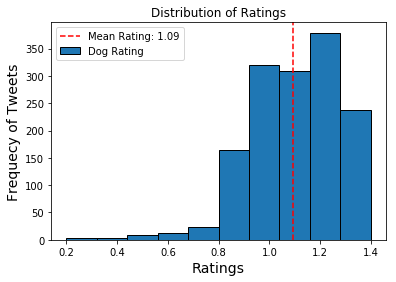

In [534]:
# distribution of ratings
rating_mean = 'Mean Rating: ' + str(final_df.rating.mean())[:4]
plt.hist(final_df.rating, label='Dog Rating', edgecolor='k')
plt.axvline(final_df.rating.mean(), color='r', label=rating_mean, linestyle='dashed')
plt.xlabel('Ratings', fontsize=14)
plt.ylabel('Frequecy of Tweets', fontsize=14)
plt.title('Distribution of Ratings')
plt.legend();

In [475]:
# see dog breeds
num_ratings_per_breed = final_df.p1.value_counts().reset_index()
num_ratings_per_breed.rename(columns={'index': 'predicted_breed', 'p1':'how_many_times'}, inplace=True)

num_ratings_per_breed.head(10)

,predicted_breed,how_many_times
0,golden_retriever,136
1,Labrador_retriever,92
2,Pembroke,88
3,Chihuahua,79
4,pug,54
5,chow,41
6,Samoyed,40
7,toy_poodle,38
8,Pomeranian,38
9,malamute,29


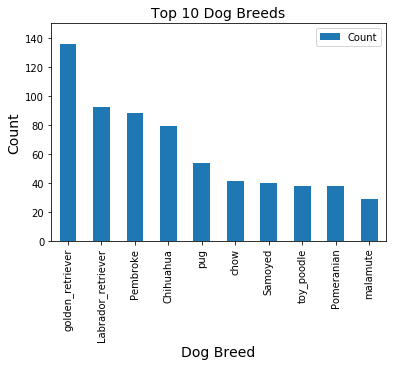

In [561]:
# bar plot of top 10 dog breeds in our datasets
num_ratings_per_breed.head(10).plot(kind='bar', x=['predicted_breed'], y=['how_many_times'])
plt.xlabel('Dog Breed', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim(ymin=0, ymax=150)
plt.title('Top 10 Dog Breeds', fontsize=14)
leg = plt.legend()
leg.get_texts()[0].set_text('Count');

In [577]:
# get average retweets and favorites with respect to ratings
rt_by_ratings = final_df.groupby(['rating'])[['retweets','favorites']].mean()
rt_by_ratings = rt_by_ratings.reset_index()
rt_by_ratings

,rating,retweets,favorites
0,0.200,2757.000000,5720.000000
1,0.300,900.666667,3202.333333
2,0.400,874.500000,2550.250000
3,0.500,873.666667,2917.444444
4,0.600,994.166667,3104.750000
5,0.700,741.458333,2157.625000
6,0.800,720.448276,2079.017241
7,0.900,780.887850,2409.233645
8,0.975,6790.000000,19714.000000
9,1.000,1306.269592,3709.561129


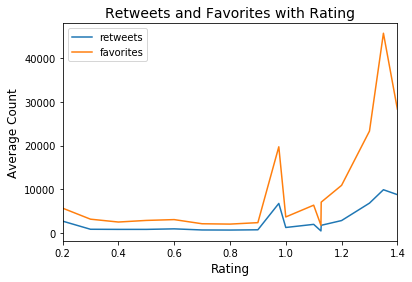

In [564]:
# plot average retweets and favorites with respect to ratings
rt_by_ratings[['rating', 'retweets', 'favorites']].plot(x='rating')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Average Count', fontsize=12)
plt.title('Retweets and Favorites with Rating', fontsize=14);

In [574]:
num_ratings_per_breed.head(10)

,predicted_breed,how_many_times
0,golden_retriever,136
1,Labrador_retriever,92
2,Pembroke,88
3,Chihuahua,79
4,pug,54
5,chow,41
6,Samoyed,40
7,toy_poodle,38
8,Pomeranian,38
9,malamute,29


In [576]:
# sort df.sort_values('2')
rt_by_breed = final_df.groupby(['p1'])[['retweets','favorites']].mean()
rt_by_breed.reset_index(inplace=True)

rt_by_breed_10 = pd.merge(left=num_ratings_per_breed, right=rt_by_breed, how='inner', left_on='predicted_breed', right_on='p1')
rt_by_breed_10 = rt_by_breed_10.head(10)
rt_by_breed_10

,predicted_breed,how_many_times,p1,retweets,favorites
0,golden_retriever,136,golden_retriever,3566.536765,12203.330882
1,Labrador_retriever,92,Labrador_retriever,3846.543478,12100.554348
2,Pembroke,88,Pembroke,3086.295455,11198.170455
3,Chihuahua,79,Chihuahua,2756.443038,8544.506329
4,pug,54,pug,1760.870370,5753.000000
5,chow,41,chow,2794.878049,9842.951220
6,Samoyed,40,Samoyed,4421.625000,13188.500000
7,toy_poodle,38,toy_poodle,2361.342105,6442.000000
8,Pomeranian,38,Pomeranian,2754.657895,7904.605263
9,malamute,29,malamute,2470.965517,8549.758621


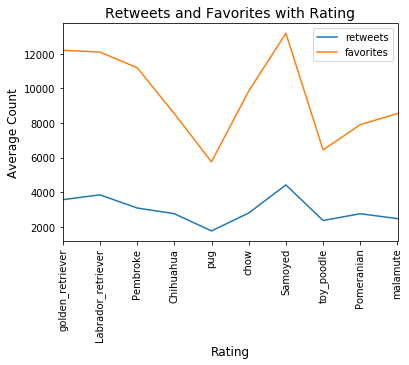

In [580]:
# plot average retweets and favorites with respect to breed
rt_by_breed_10[['p1', 'retweets', 'favorites']].plot(x='p1')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Average Count', fontsize=12)
plt.xticks(rotation=90)
plt.title('Retweets and Favorites with Rating', fontsize=14);